In [1]:
# https://www.kaggle.com/datasets/andrewmvd/animal-faces

In [2]:
#!/bin/bash
!curl -L -o ./animal-faces.zip https://www.kaggle.com/api/v1/datasets/download/andrewmvd/animal-faces

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  695M  100  695M    0     0  21.5M      0  0:00:32  0:00:32 --:--:-- 22.3M


In [3]:
!unzip -q animal-faces.zip -d animal-faces

In [4]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

In [5]:
# Base directory
base_dir = Path('./animal-faces/afhq')

# Get all .jpg files under base_dir (recursively)
image_paths = list(base_dir.glob('**/*.jpg'))

# Build list of (image_path, label) tuples
data = []
for path in image_paths:
    label = path.parent.name  # 'cat', 'dog', or 'wild'
    data.append((str(path), label))

# Create DataFrame
df = pd.DataFrame(data, columns=['image_path', 'label'])
df.shape


(16130, 2)

In [6]:
df.head()

,image_path,label
0,animal-faces/afhq/val/cat/pixabay_cat_000010.jpg,cat
1,animal-faces/afhq/val/cat/pixabay_cat_002133.jpg,cat
2,animal-faces/afhq/val/cat/pixabay_cat_002696.jpg,cat
3,animal-faces/afhq/val/cat/flickr_cat_000076.jpg,cat
4,animal-faces/afhq/val/cat/pixabay_cat_000276.jpg,cat


In [7]:
# # for testing purpose
# df = df.sample(frac=.3)

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [10]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torch.optim.lr_scheduler import ReduceLROnPlateau

In [11]:
from torchvision.transforms import transforms

In [12]:
# df_train = df.sample(frac=.7)
# df_test = df.drop(df_train.index)

# df_val = df_test.sample(frac=.5)
# df_test = df_test.drop(df_val.index)

# len(df_train), len(df_val), len(df_test)

# Read the dataframe (assuming df is already created)
label_to_idx = {label: idx for idx, label in enumerate(df['label'].unique())}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

df['label_idx'] = df['label'].map(label_to_idx)

# Split: 80% train, 10% val, 10% test
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label_idx'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label_idx'], random_state=42)

len(train_df), len(val_df), len(test_df)

(11291, 2419, 2420)

In [13]:
class AnimalFacesDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.loc[idx, 'image_path']
        label = self.df.loc[idx, 'label_idx']
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [14]:
image_size = 128
batch_size = 32

train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

train_ds = AnimalFacesDataset(train_df, transform=train_transform)
val_ds = AnimalFacesDataset(val_df, transform=test_transform)
test_ds = AnimalFacesDataset(test_df, transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)


In [15]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (image_size // 8) * (image_size // 8), 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.fc_stack(x)
        return x


In [16]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, correct = 0.0, 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == targets).sum().item()
    return total_loss / len(dataloader.dataset), correct / len(dataloader.dataset)


def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct = 0.0, 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            correct += (outputs.argmax(1) == targets).sum().item()
    return total_loss / len(dataloader.dataset), correct / len(dataloader.dataset)


In [17]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [18]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = CNNClassifier(num_classes=len(label_to_idx)).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
# early_stopper = EarlyStopping(patience=3, min_delta=0.001)

# epochs = 10

# train_losses, val_losses = [], []
# train_accs, val_accs = [], []

# for epoch in range(epochs):
#     train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
#     val_loss, val_acc = evaluate(model, val_loader, criterion, device)

#     train_losses.append(train_loss)
#     val_losses.append(val_loss)
#     train_accs.append(train_acc)
#     val_accs.append(val_acc)

#     scheduler.step(val_loss)
#     early_stopper(val_loss)

#     print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
#           f"Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

#     if early_stopper.early_stop:
#         print("Early stopping triggered. Training stopped.")
#         break


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNClassifier(num_classes=len(label_to_idx)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
early_stopper = EarlyStopping(patience=3, min_delta=0.001)

# ✅ Track best validation loss to save best model
best_val_loss = float('inf')
best_model_path = "best_model.pth"

epochs = 20
train_losses, val_losses = [], []
train_accs, val_accs = [], []
lr_history = []

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # 🔧 Adjust learning rate
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    lr_history.append(current_lr)

    # 💾 Save model if it's the best so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Best model saved at epoch {epoch+1} (val_loss: {val_loss:.4f})")

    # ⏹️ Early stopping check
    early_stopper(val_loss)
    if early_stopper.early_stop:
        print("⛔ Early stopping triggered. Training stopped.")
        break

    print(f"📊 Epoch {epoch+1}: "
          f"Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
          f"Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")
    print()

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


✅ Best model saved at epoch 1 (val_loss: 0.2121)
📊 Epoch 1: Train Loss=0.4438, Val Loss=0.2121, Train Acc=0.8159, Val Acc=0.9210

✅ Best model saved at epoch 2 (val_loss: 0.1268)
📊 Epoch 2: Train Loss=0.1676, Val Loss=0.1268, Train Acc=0.9386, Val Acc=0.9549

📊 Epoch 3: Train Loss=0.1084, Val Loss=0.1551, Train Acc=0.9605, Val Acc=0.9450

✅ Best model saved at epoch 4 (val_loss: 0.0963)
📊 Epoch 4: Train Loss=0.0775, Val Loss=0.0963, Train Acc=0.9725, Val Acc=0.9587

✅ Best model saved at epoch 5 (val_loss: 0.0801)
📊 Epoch 5: Train Loss=0.0577, Val Loss=0.0801, Train Acc=0.9788, Val Acc=0.9682

📊 Epoch 6: Train Loss=0.0459, Val Loss=0.0863, Train Acc=0.9840, Val Acc=0.9682

✅ Best model saved at epoch 7 (val_loss: 0.0662)
📊 Epoch 7: Train Loss=0.0400, Val Loss=0.0662, Train Acc=0.9851, Val Acc=0.9723

📊 Epoch 8: Train Loss=0.0364, Val Loss=0.0793, Train Acc=0.9853, Val Acc=0.9702

📊 Epoch 9: Train Loss=0.0258, Val Loss=0.0732, Train Acc=0.9903, Val Acc=0.9727

⛔ Early stopping triggered

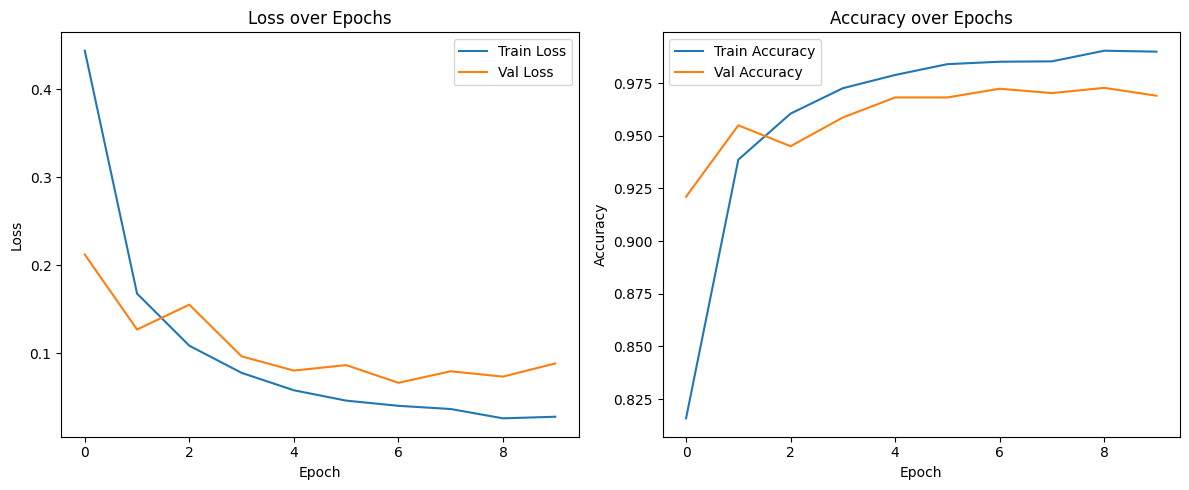

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_title("Loss over Epochs")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(val_accs, label='Val Accuracy')
ax2.set_title("Accuracy over Epochs")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.tight_layout()
plt.show()


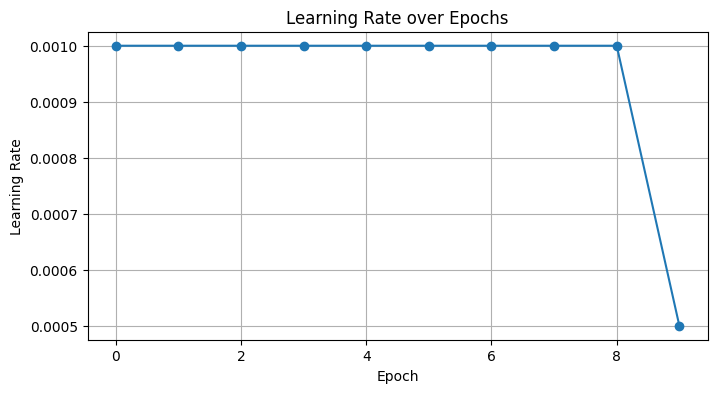

In [21]:
plt.figure(figsize=(8, 4))
plt.plot(lr_history, marker='o')
plt.title("Learning Rate over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.show()

In [22]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc * 100:.2f}%")


Test Loss: 0.0929 | Test Accuracy: 96.90%


In [23]:
def predict_image(image_path, model, transform, idx_to_label, device):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1).squeeze()

    # Convert to dict of {label: prob}
    prob_dict = {
        idx_to_label[i]: float(probabilities[i])
        for i in range(len(probabilities))
    }

    # Sort by probability descending
    return dict(sorted(prob_dict.items(), key=lambda item: item[1], reverse=True))


In [24]:
# image_path = "./cat.jpg"
# predictions = predict_image(image_path, model, test_transform, idx_to_label, device)

# for label, prob in predictions.items():
#     print(f"{label}: {prob:.4f}")


In [25]:
def show_prediction(image_path, model, transform, idx_to_label, device, actual_label=None, topk=3):
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Get prediction
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1).squeeze().cpu().numpy()

    # Get top-k predictions
    top_indices = probs.argsort()[::-1][:topk]
    top_labels = [idx_to_label[i] for i in top_indices]
    top_probs = [probs[i] for i in top_indices]

    # 🖼️ Plot image with prediction title
    img_display = mpimg.imread(image_path)
    plt.figure(figsize=(5, 5))
    plt.imshow(img_display)
    plt.axis('off')

    # Title with predicted + actual label
    pred_label = top_labels[0]
    pred_prob = top_probs[0]
    title = f"Predicted: {pred_label} ({pred_prob:.2f})"
    if actual_label:
        title += f"\nActual: {actual_label}"
    plt.title(title, fontsize=12)
    plt.show()

    # 📋 Print all top-k probabilities
    print("🔍 Prediction Probabilities:")
    for lbl, pr in zip(top_labels, top_probs):
        print(f"{lbl}: {pr:.4f}")


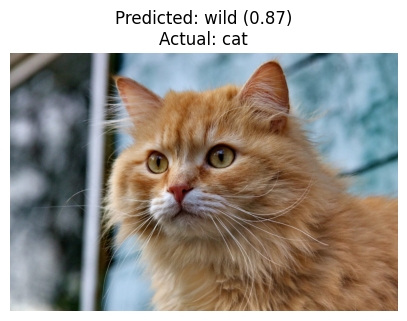

🔍 Prediction Probabilities:
wild: 0.8688
cat: 0.1250
dog: 0.0062


In [27]:
image_path = "./cat.jpg"
show_prediction(image_path, model, test_transform, idx_to_label, device, actual_label="cat")


In [28]:
# def predict_top_k(image_path, model, transform, idx_to_label, device, k=3):
#     image = Image.open(image_path).convert("RGB")
#     image_tensor = transform(image).unsqueeze(0).to(device)

#     model.eval()
#     with torch.no_grad():
#         outputs = model(image_tensor)
#         probs = torch.softmax(outputs, dim=1)

#     top_probs, top_indices = torch.topk(probs, k)
#     top_probs = top_probs.squeeze().cpu().numpy()
#     top_indices = top_indices.squeeze().cpu().numpy()

#     results = [(idx_to_label[idx], float(prob)) for idx, prob in zip(top_indices, top_probs)]
#     return results


In [29]:
# def get_predictions(model, dataloader, device):
#     model.eval()
#     all_preds = []
#     all_probs = []
#     all_labels = []
#     all_paths = []

#     with torch.no_grad():
#         for inputs, labels in dataloader.dataset:
#             if hasattr(dataloader.dataset, 'df'):
#                 img_path = dataloader.dataset.df['image_path'].iloc[len(all_labels)]
#             else:
#                 img_path = None  # fallback if path isn't known
#             print(img_path)
#             input_tensor = inputs.unsqueeze(0).to(device)
#             outputs = model(input_tensor)
#             probs = torch.softmax(outputs, dim=1).squeeze()
#             pred = torch.argmax(probs).item()

#             all_preds.append(pred)
#             all_probs.append(probs.cpu().numpy())
#             all_labels.append(labels)
#             all_paths.append(img_path)

#     return {
#         "preds": all_preds,
#         "probs": all_probs,
#         "labels": all_labels,
#         "paths": all_paths
#     }

def get_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    all_paths = []

    idx = 0  # to track image_path from df

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            batch_size = inputs.size(0)
            for i in range(batch_size):
                if hasattr(dataloader.dataset, 'df'):
                    img_path = dataloader.dataset.df['image_path'].iloc[idx]
                else:
                    img_path = None
                all_preds.append(preds[i].item())
                all_probs.append(probs[i].cpu().numpy())
                all_labels.append(labels[i].item())
                all_paths.append(img_path)
                idx += 1

    return {
        "preds": all_preds,
        "probs": all_probs,
        "labels": all_labels,
        "paths": all_paths
    }


In [30]:
def get_misclassified(pred_dict, idx_to_label):
    misclassified = []

    for pred, label, path, prob in zip(
        pred_dict['preds'],
        pred_dict['labels'],
        pred_dict['paths'],
        pred_dict['probs']
    ):
        if pred != label:
            misclassified.append({
                "image_path": path,
                "true_label": idx_to_label[label],
                "predicted_label": idx_to_label[pred],
                "confidence": prob[pred]
            })

    return misclassified


In [31]:
def plot_misclassified(misclassified_list, n=9):
    n = min(n, len(misclassified_list))
    cols = 3
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(12, 4 * rows))

    for i in range(n):
        item = misclassified_list[i]
        img = mpimg.imread(item['image_path'])

        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"True: {item['true_label']}\nPred: {item['predicted_label']} ({item['confidence']:.2f})")

    plt.tight_layout()
    plt.show()


In [32]:
# Evaluate on validation set
preds_val = get_predictions(model, val_loader, device)
misclassified_val = get_misclassified(preds_val, idx_to_label)


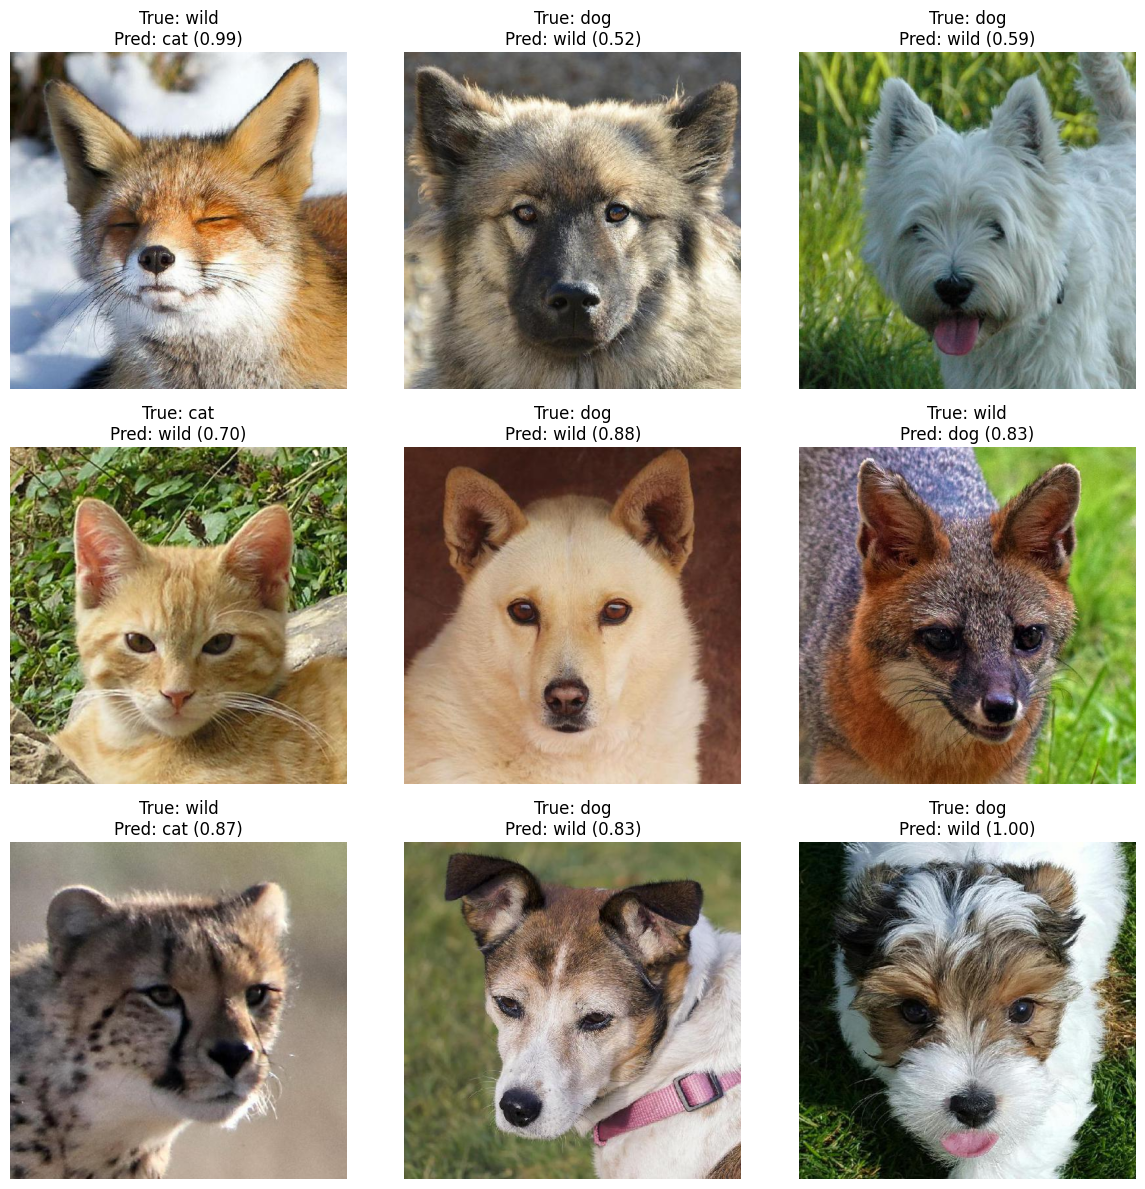

In [33]:
plot_misclassified(misclassified_val, n=9)
